## Import Libraries and Models

In [1]:
import cv2
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 5)

from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import hydra
from hydra import initialize
from diffusers import StableDiffusionBrushNetPipeline, BrushNetModel, UniPCMultistepScheduler
from mmpose.apis import init_pose_model, inference_top_down_pose_model, vis_pose_result

/work/u6999445/DeepSpeedExamples/applications/DeepSpeed-Chat/sam2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()
/work/u6999445/miniforge3/envs/cvpdl-final/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

using device: cuda


In [3]:
yolo_model = YOLO("yolo11x.pt")

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="sam2")
sam2_checkpoint = "sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
sam2_predictor = SAM2ImagePredictor(sam2_model)

base_model_path = "../BrushNet/examples/brushnet/data/ckpt/realisticVisionV60B1_v51VAE"
brushnet_path = "../BrushNet/examples/brushnet/data/ckpt/random_mask_brushnet_ckpt"
brushnet = BrushNetModel.from_pretrained(brushnet_path, torch_dtype=torch.float16)
pipe = StableDiffusionBrushNetPipeline.from_pretrained(
    base_model_path, brushnet=brushnet, torch_dtype=torch.float16, low_cpu_mem_usage=False
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

config_file = "ViTPose/mmpose_configs/ViTPose_base_ochuman_256x192.py"
checkpoint_file = "ViTPose/ckpt/vitpose_base_coco_aic_mpii.pth"
pose_model = init_pose_model(config_file, checkpoint_file, device=device) 

/tmp/ipykernel_10596/2935857004.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="sam2")
Loading pipeline components...: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


## Masking


0: 640x512 3 persons, 1 sports ball, 44.1ms
Speed: 5.7ms preprocess, 44.1ms inference, 55.8ms postprocess per image at shape (1, 3, 640, 512)


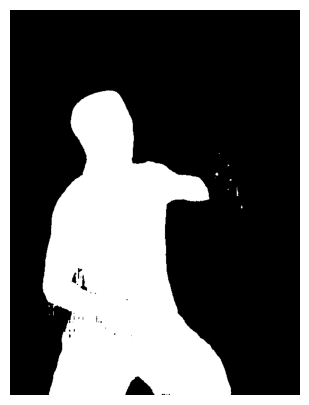

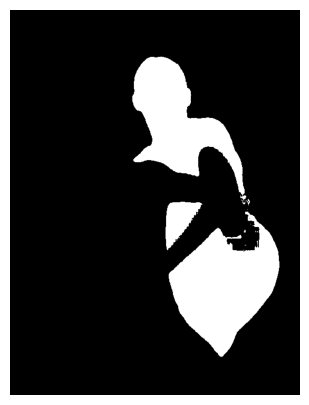

In [4]:
image_path = 'sample_image/000144.jpg'

image = cv2.imread(image_path)
height, width, channels = image.shape

results = yolo_model(image)

sam2_predictor.set_image(image)
annotations = []
for result in results:
    confidences = result.boxes.conf.float().tolist()
    class_ids = result.boxes.cls.int().tolist()
    if len(class_ids):
        boxes = result.boxes.xyxy
        for i in range(len(class_ids)):
            if class_ids[i] == 0 and confidences[i] > 0.3:
                input_box = np.array(boxes[i].cpu())

                masks, scores, _ = sam2_predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False,
                )

                annotations.append(masks[0])

masks = [np.ones((height, width, 3), dtype=np.uint8) * 255 for _ in range(len(annotations))]

for i, mask in enumerate(annotations):
    canvas = np.zeros(image.shape, image.dtype) + (0, 0, 0)
    masks[i][mask > 0] = canvas[mask > 0]
    masks[i] = 255 - masks[i]

for i in range(len(masks)):
    plt.imshow(masks[i][:,:,::-1])
    plt.axis('off')
    plt.show()

## Inpainting

100%|██████████| 50/50 [00:07<00:00,  6.71it/s]


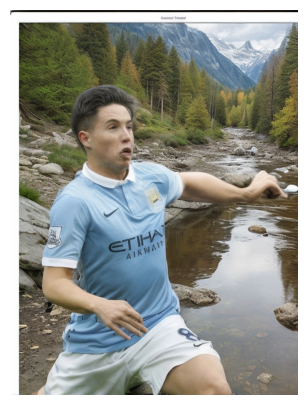

100%|██████████| 50/50 [00:07<00:00,  6.85it/s]


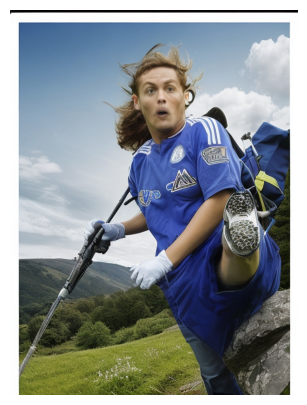

100%|██████████| 2/2 [00:18<00:00,  9.10s/it]


In [5]:
caption = "image repair with landscape"
negative_prompt = "human"
brushnet_conditioning_scale = 1.0

inpainted_images = []
for mask in tqdm(masks):
    init_image = image[:, :, ::-1]
    input_mask = mask
    mask_image = 1.*(input_mask.sum(-1)<255)[:,:,np.newaxis]
    init_image = init_image * (1 - mask_image)

    init_image = Image.fromarray(init_image.astype(np.uint8)).convert("RGB")
    mask_image = Image.fromarray(mask_image.astype(np.uint8).repeat(3, -1) * 255).convert("RGB")

    generator = torch.Generator("cuda").manual_seed(1234)

    inpainted_image = pipe(
        caption,
        init_image,
        mask_image,
        num_inference_steps=50,
        generator=generator,
        brushnet_conditioning_scale=brushnet_conditioning_scale,
        negative_prompt=negative_prompt
    ).images[0]

    inpainted_images.append(inpainted_image)
    plt.imshow(inpainted_image)
    plt.axis('off')
    plt.show()

## Pose Estimation

Use load_from_local loader
The model and loaded state dict do not match exactly

unexpected key in source state_dict: associate_keypoint_heads.0.deconv_layers.0.weight, associate_keypoint_heads.0.deconv_layers.1.weight, associate_keypoint_heads.0.deconv_layers.1.bias, associate_keypoint_heads.0.deconv_layers.1.running_mean, associate_keypoint_heads.0.deconv_layers.1.running_var, associate_keypoint_heads.0.deconv_layers.1.num_batches_tracked, associate_keypoint_heads.0.deconv_layers.3.weight, associate_keypoint_heads.0.deconv_layers.4.weight, associate_keypoint_heads.0.deconv_layers.4.bias, associate_keypoint_heads.0.deconv_layers.4.running_mean, associate_keypoint_heads.0.deconv_layers.4.running_var, associate_keypoint_heads.0.deconv_layers.4.num_batches_tracked, associate_keypoint_heads.0.final_layer.weight, associate_keypoint_heads.0.final_layer.bias, associate_keypoint_heads.1.deconv_layers.0.weight, associate_keypoint_heads.1.deconv_layers.1.weight, associate_keypoint_heads.1.decon

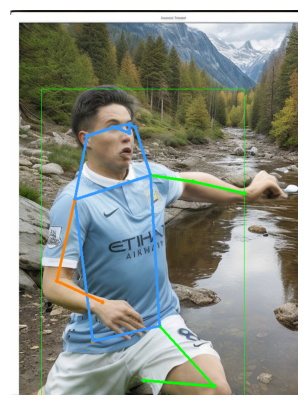

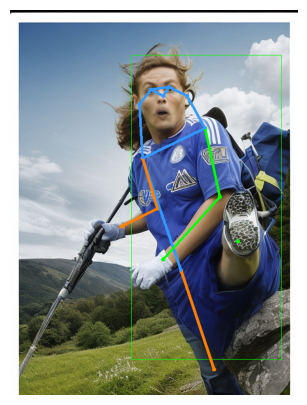

In [11]:
def mask_to_bbox(mask):
    rows = np.any(mask == 255, axis=1)
    cols = np.any(mask == 255, axis=0)
    if not np.any(rows) or not np.any(cols):
        return None
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    return x_min, y_min, x_max, y_max

bboxes = [mask_to_bbox(mask) for mask in masks]

line_thickness = 3
keypoint_radius = 4

total_keypoints = []

for bbox, inpainted_image in zip(bboxes, inpainted_images):
    x_min, y_min, x_max, y_max = bbox
    
    expand_amount = 3
    x_min = max(0, x_min - expand_amount)
    y_min = max(0, y_min - expand_amount)
    x_max = x_max + expand_amount
    y_max = y_max + expand_amount

    width = x_max - x_min
    height = y_max - y_min

    person_results = [{'bbox': [x_min, y_min, width, height] + [1]}]

    pose_results, _ = inference_top_down_pose_model(
        pose_model,
        np.array(inpainted_image),
        person_results=person_results,
        format='xywh',
        bbox_thr=0.5,
        dataset='TopDownOCHumanDataset',
        return_heatmap=False
    )

    vis_result = vis_pose_result(
        pose_model,
        np.array(inpainted_image),
        pose_results,
        dataset='TopDownOCHumanDataset',
        show=False,
        kpt_score_thr=0.5,
        radius=keypoint_radius,
        thickness=line_thickness
    )

    plt.imshow(vis_result)
    plt.axis('off')
    plt.show()

    for result in pose_results:
        result['keypoints'] = result['keypoints'].astype(np.float64)
        keypoints = []

        for kp in result['keypoints']:
            x, y, visibility = kp
            keypoints.extend([x, y, visibility])

        total_keypoints.append(keypoints)

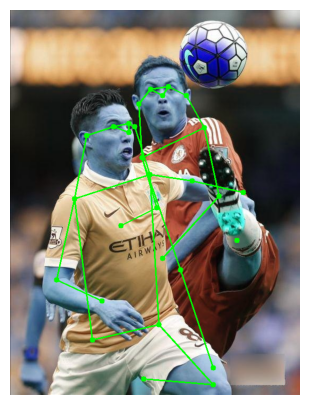

In [13]:
SKELETON = [
    [16, 14], [14, 12], [17, 15], [15, 13], [12, 13], 
    [6, 12], [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], 
    [9, 11], [2, 3], [1, 2], [1, 3], [2, 4], [3, 5], 
    [4, 6], [5, 7]
]

for i in range(len(SKELETON)):
    SKELETON[i][0] -= 1
    SKELETON[i][1] -= 1

thickness = 2
radius = 5

for keypoints in total_keypoints:
    for i in range(0, len(keypoints), 3):
        x, y, visibility = keypoints[i], keypoints[i + 1], keypoints[i + 2]
        if visibility > 0.5:
            cv2.circle(image, (int(x), int(y)), radius, (0, 255, 0), -1)

    for joint_start, joint_end in SKELETON:
        x_start, y_start, visibility_start = keypoints[joint_start * 3], keypoints[joint_start * 3 + 1], keypoints[joint_start * 3 + 2]
        x_end, y_end, visibility_end = keypoints[joint_end * 3], keypoints[joint_end * 3 + 1], keypoints[joint_end * 3 + 2]

        if visibility_start > 0.5 and visibility_end > 0.5:
            cv2.line(image, (int(x_start), int(y_start)), (int(x_end), int(y_end)), (0, 255, 0), thickness)

plt.imshow(image)
plt.axis('off')
plt.show()